## 目的
本ノートブックでは、画像からパラメータを推定する回帰モデルを構築する。  
タスクとしては人の顔画像から年齢を推定するといったものと同様である。  
推定する対象は連星ブラックホールの有効スピンである。有効スピンは連星ブラックホール合体の重力波信号から最も精度良く測定できる天体の回転パラメータであるとされている。
有効スピンは$c=G=1$の単位系で以下のように定義される。
\begin{equation}
\chi_{eff} = \frac{{S_1}/{m_1} + {S_2}/{m_2}}{m_1+m_2}\cdot \frac{{L}}{|{L}|} = \frac{m_1\chi_1 + m_2\chi_2}{m_1 + m_2}
\end{equation}
$m_{1,2},{S_{1,2}},{L}$はそれぞれ連星をなすブラックホールの個々の質量、個々のスピン角運動量ベクトル、軌道角運動量ベクトルを表す。また、$\chi_{1,2}$は個々のブラックホールの無次元スピンパラメータを表す。

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL
import csv
import torch
import torchvision

In [2]:
import random
torch.manual_seed(12)
np.random.seed(12)
random.seed(12)

In [3]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, label_path, transform=None):
        x = []
        y = []
        file = open(label_path, 'r')
        data = csv.reader(file)
        for row in data:
            x.append(row[0])
            y.append(float(row[1]))
        file.close()
    
        self.x = x    
        self.y = torch.from_numpy(np.array(y)).float().view(-1, 1)
     
        self.transform = transform
  
  
    def __len__(self):
        return len(self.x)
  
  
    def __getitem__(self, i):
        img = PIL.Image.open(self.x[i]).convert('RGB')
        if self.transform is not None:
              img = self.transform(img)
    
        return img, self.y[i]

In [4]:
transform = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Resize(26),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_data_dir = './csv/effspin8_train.csv'
valid_data_dir = './csv/effspin8_val.csv'
test_data_dir = './csv/effspin8_test.csv'
data_dir = './csv/actual_test.csv'
spin_dir = './csv/spintest.csv'

trainset = MyDataset(train_data_dir, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)

validset = MyDataset(valid_data_dir, transform=transform)
validloader = torch.utils.data.DataLoader(validset, batch_size=4, shuffle=False)

testset = MyDataset(test_data_dir, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

spintestset = MyDataset(spin_dir, transform=transform)
spintestloader = torch.utils.data.DataLoader(spintestset, batch_size=1, shuffle=False)


gwset = MyDataset(data_dir, transform=transform)
gwloader = torch.utils.data.DataLoader(gwset, batch_size=1, shuffle=False)

In [5]:
class RegressionNet(torch.nn.Module):

    def __init__(self):
        super(RegressionNet, self).__init__()

        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.pool2 = torch.nn.MaxPool2d(2, 2)

        self.fc1 = torch.nn.Linear(32 * 5 * 5, 1024)
        self.fc2 = torch.nn.Linear(1024, 1024)
        self.fc3 = torch.nn.Linear(1024, 1)


    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.pool2(x)

        x = x.view(-1, 32 * 5 * 5)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x

net = RegressionNet()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

In [6]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

In [7]:
import time
num_epocs = 50

list1=[]
list2=[]

train_loss = []
valid_loss = []
time_sta = time.time()
for epoch in range(num_epocs):
  # 学習
    net.train()
    running_train_loss = 0.0
    running_acc = 0.0
    with torch.set_grad_enabled(True):
        for data in trainloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            a = outputs.tolist()
            b = labels.tolist()
            list1.append(a)
            list2.append(b)
            loss = criterion(outputs, labels)
            running_train_loss += loss.item()
            loss.backward()
            optimizer.step()

    train_loss.append(running_train_loss / len(trainloader))
  
  # 検証
    net.eval()
    running_valid_loss = 0.0
    val_running_acc = 0.0
    with torch.set_grad_enabled(False):
        for data in validloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_valid_loss += loss.item()

    valid_loss.append(running_valid_loss / len(validloader))

    print('#epoch:{}\ttrain loss: {}\tvalid loss: {}'.format(epoch,
                                                running_train_loss / len(trainloader), 
                                                running_valid_loss / len(validloader)))
    
time_end = time.time()
tim = time_end- time_sta
print(tim)

#epoch:0	train loss: 0.16659738661944867	valid loss: 0.1211265639560297
#epoch:1	train loss: 0.10372983710765839	valid loss: 0.1045445234393701
#epoch:2	train loss: 0.09024082541018724	valid loss: 0.08808470565639437
#epoch:3	train loss: 0.0819540797971189	valid loss: 0.0818699501324445
#epoch:4	train loss: 0.07623754684180022	valid loss: 0.07723705305717886
#epoch:5	train loss: 0.07092050104513764	valid loss: 0.06938016965147108
#epoch:6	train loss: 0.06670251156389713	valid loss: 0.065818228517659
#epoch:7	train loss: 0.06337662832587958	valid loss: 0.06223270510463044
#epoch:8	train loss: 0.061224553100019695	valid loss: 0.06517292386572808
#epoch:9	train loss: 0.05899211440756917	valid loss: 0.07412129804398865
#epoch:10	train loss: 0.05764644312337041	valid loss: 0.05842268615961075
#epoch:11	train loss: 0.05609352392479777	valid loss: 0.05588314260309562
#epoch:12	train loss: 0.05564390632659197	valid loss: 0.056818541776854546
#epoch:13	train loss: 0.054130239153653385	valid los

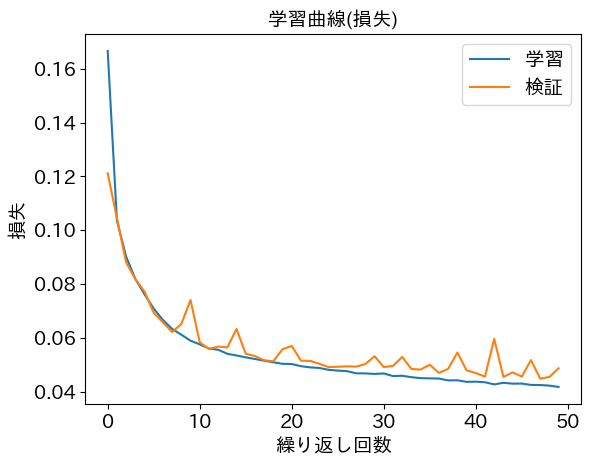

In [8]:
import japanize_matplotlib
plt.plot(train_loss, label='学習')
plt.plot(valid_loss, label='検証')
plt.xlabel('繰り返し回数',fontsize=14)
plt.ylabel('損失',fontsize=14)
plt.title('学習曲線(損失)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [9]:
test_loss=[]
running_test_loss = 0.0
pred=[]
ans=[]
with torch.set_grad_enabled(False):
    for data in testloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        list1 = labels.tolist()
        outputs = net(inputs)
        list2 = outputs.tolist()
        for i in range(len(list1)):
            ans.append(list1[i])
        for i in range(len(list2)):
            pred.append(list2[i])
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()

test_loss.append(running_test_loss / len(testloader))

print('test loss: {}'.format(running_test_loss / len(testloader)))
                

test loss: 0.050298586882062665


In [10]:
import collections

def flatten(l):
    for el in l:
        if isinstance(el, collections.abc.Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el
            

In [11]:
ans= list(flatten(ans))
pred= list(flatten(pred))

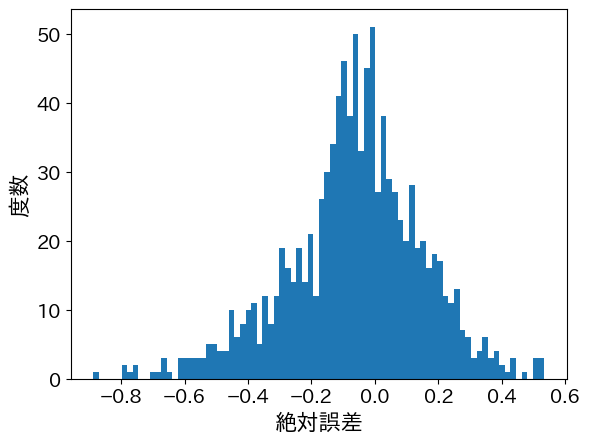

0.5338128600269556
-0.8876067101955414
-0.06485695201077032
0.2147982788358349


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
warnings.simplefilter('ignore')
import japanize_matplotlib
import statistics
ans= list(flatten(ans))
pred= list(flatten(pred))

abser=[]
for i in range(len(ans)):
    abser.append(pred[i]-ans[i])
    
plt.hist(abser,bins=80)
plt.xlabel('絶対誤差',fontsize=16)
plt.ylabel('度数',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

print(max(abser))
print(min(abser))
print(statistics.mean(abser))
print(statistics.stdev(abser))


最大で0.534の誤差があり、平均は-0.065、標準偏差は0.215となった。
推定における絶対誤差が母平均$\mu$母分散$\sigma^2$の正規分布に従うと仮定し、母分散が未知の場合の母平均の区間推定を行った。
まず、次の変数を定義する。
\begin{equation}
U \equiv \frac{\bar{X}-\mu}{\sqrt{\frac{S^2}{n}}}
\end{equation}


\begin{equation}
\bar{X} = \frac{1}{n}\sum_{i=1}^n X_i, \:\:\:\:\:\:     S^2 = \frac{1}{n-1}\sum_{i=1}^n (X_i -\bar{X})^2
\end{equation}
ここで$X_i$は測定された絶対誤差、nはテストデータの件数(今回は1000)。
Uは自由度(n-1)のt分布に従うので、そこから決まるある定数$u_{n-1}(\frac{\alpha}{2})$を用いて母平均$\mu$の信頼係数$1-\alpha$の信頼区間は以下のように決まる。
\begin{equation}
\bar{X}-u_{n-1}(\frac{\alpha}{2})\cdot\sqrt{\frac{S^2}{n}}\leq\mu\leq\bar{X}+u_{n-1}(\frac{\alpha}{2})\cdot\sqrt{\frac{S^2}{n}}
\end{equation}
従って、今回用意した1000件のテストデータに対しては68％信頼区間において
\begin{equation}
-0.065 - 0.002\leq \mu \leq -0.065+0.002
\end{equation}
よって、系統誤差は存在するが標準偏差が0.214であることより、統計誤差に比べて1桁小さいため今回用意した1000件のテストデータに対しては正しく推定できている。



(array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

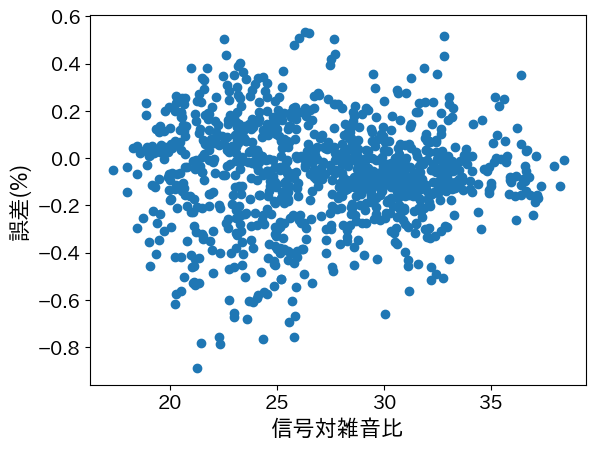

In [18]:
abser2=[]
for i in range(len(abser)):
    abser2.append(abs(abser[i]))
    
plt.scatter(snr,abser)
plt.xlabel('信号対雑音比',fontsize=16)
plt.ylabel('誤差(%)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


In [57]:
for i in range(len(abser)):
    if abser[i]>=0.2:
        print(ans[i],pred[i],abser[i])

-0.8821815252304077 -0.6747686862945557 0.20741283893585205
-0.8826935291290283 -0.6147067546844482 0.2679867744445801
-0.40712758898735046 -0.19642877578735352 0.21069881319999695
-0.9464878439903259 -0.6018845438957214 0.3446033000946045


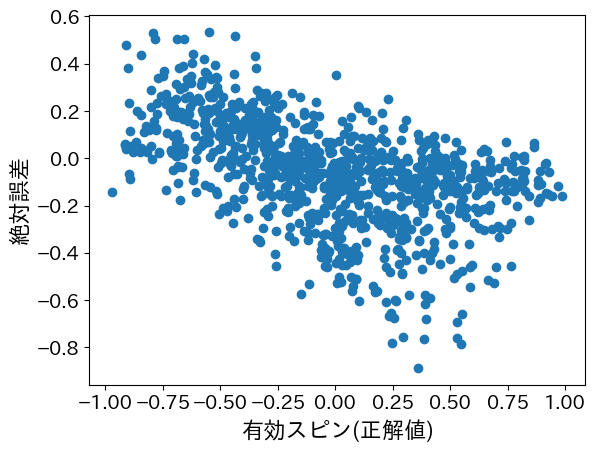

In [17]:
plt.xlabel('有効スピン(正解値)',fontsize=16)
plt.ylabel('絶対誤差',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(ans,abser)

In [38]:
error=[]
for i in range(len(ans)):
    error.append((pred[i]/ans[i])-1)
    
    

In [14]:
snr =[]
file = open('./csv/effspin8_test.csv', 'r')
data = csv.reader(file)
for row in data:
    snr.append(float(row[2]))
file.close()

In [79]:
test_loss=[]
running_test_loss = 0.0
pred=[]
ans=[]
with torch.set_grad_enabled(False):
    for data in spintestloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        list1 = labels.tolist()
        outputs = net(inputs)
        list2 = outputs.tolist()
        for i in range(len(list1)):
            ans.append(list1[i])
        for i in range(len(list2)):
            pred.append(list2[i])
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()

test_loss.append(running_test_loss / len(spintestloader))

print('test loss: {}'.format(running_test_loss / len(spintestloader)))
                

test loss: 0.3417643684116588
